# Flight Ticket Price Prediction System

### **Aim**

This project aims to build a machine learning model to predict flight prices for different flights based on various features like Date of journey, Source City, Destination City, Duration, Airline, etc..

### **About the dataset**

The Airfare ML dataset is a single CSV file that contains over 4 lakh records of domestic flights operated acorss India. The data is collected from 16 th January 2023 to 8th March 2023. The features provided include the Date of Booking, Date of Journey, Airline-Class, Departure Time, Arrival Time, Duration, Total Stops. The target variable is the price of the flight, which is provided in Indian Rupees (INR).

In [44]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/airfare-ml-predicting-flight-fares/Scraped_dataset.csv
/kaggle/input/airfare-ml-predicting-flight-fares/Cleaned_dataset.csv


### **Import the Libraries**

In [45]:
#Import the necessary libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score


from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

### **Load the dataset**

In [46]:
df = pd.read_csv('/kaggle/input/airfare-ml-predicting-flight-fares/Scraped_dataset.csv')
df.head(3)

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price
0,15/01/2023,16/01/2023,SpiceJet \nSG-8169\nECONOMY,20:00\nDelhi,22:05\nMumbai,02h 05m,non-stop,"5,335"
1,15/01/2023,16/01/2023,Indigo \n6E-2519\nECONOMY,23:00\nDelhi,01:20\nMumbai,02h 20m,non-stop,"5,899"
2,15/01/2023,16/01/2023,GO FIRST \nG8- 354\nECONOMY,22:30\nDelhi,00:40\nMumbai,02h 10m,non-stop,"5,801"


### **Understanding the data**

In [47]:
df.shape

(452088, 8)

The dataset have over 4 lakh rows and 8 columns.

In [48]:
df.info() #general information about data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452088 entries, 0 to 452087
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Date of Booking  452088 non-null  object
 1   Date of Journey  452088 non-null  object
 2   Airline-Class    452088 non-null  object
 3   Departure Time   452088 non-null  object
 4   Arrival Time     452088 non-null  object
 5   Duration         452088 non-null  object
 6   Total Stops      452088 non-null  object
 7   Price            452088 non-null  object
dtypes: object(8)
memory usage: 27.6+ MB


There are no missing values in the dataset. All the columns are in string datatype. We need to convert the dtypes of those columns.

### **Data Preprocessing**

* Changing the format of the data
* Creating new columns
* Splitting the columns
* Dropping less important columns
* Removing duplicates

In [49]:
#Split the Airline-Class column into three columns

df[["Airline","Flight_Code","Class"]] = df["Airline-Class"].str.split('\n',expand=True)

In [50]:
#Split the Departure Time column 

df[["Departure","Source"]] = df["Departure Time"].str.split('\n',expand=True)

In [51]:
#Split the Arrival Time column

df[["Arrival","Destination"]] = df["Arrival Time"].str.split('\n',expand=True)

In [52]:
#Convert Date columns into datetime format

df["Date of Booking"] = pd.to_datetime(df["Date of Booking"],format = "%d/%m/%Y")
df["Date of Journey"] = pd.to_datetime(df["Date of Journey"],format = "%d/%m/%Y")

In [53]:
#Create a new column Days_left which is the no of days before the journey, booking was done

df["Days_left"] = [int(i.days) for i in (df['Date of Journey'] - df['Date of Booking'])]

In [54]:
#drop the columns which are no longer needed

df.drop(["Date of Booking","Airline-Class","Departure Time","Arrival Time"],axis=1,inplace=True)

In [55]:
#create a new column journey_day
df["Journey_day"] = df["Date of Journey"].dt.day_name()

In [56]:
#convert the departure and arrival columns to time 
df["Departure"]=pd.to_datetime(df['Departure'], format = '%H:%M').dt.time
df["Arrival"] = pd.to_datetime(df["Arrival"],format = "%H:%M").dt.time

In [57]:
#function to return only the hour from H:M format

def get_hr(time):
  h,m,s = time.split(':')
  return int(h)

In [58]:
#apply the function 
df["Departure"] = df["Departure"].apply(lambda x:str(x))
df["Departure"] = df["Departure"].apply(lambda x:get_hr(x))
df["Arrival"] = df["Arrival"].apply(lambda x:str(x))
df["Arrival"] = df["Arrival"].apply(lambda x:get_hr(x))

In [59]:

def get_part_of_day(hour):
  return(
      "Early Morning" if 0<= hour <5
      else
      "Morning" if 5<= hour <12
      else
      "Afternoon" if 12<= hour <16
      else
      "Evening"   if 16<=hour<19
      else
      "Night" if 19<=hour<22
      else
      "Late Night" 
  )


#Create 2 new columns indicating which part of the day arrival and departure happens

df["Dep"] = df["Departure"].apply(lambda x:get_part_of_day(x))
df["Arr"] = df["Arrival"].apply(lambda x:get_part_of_day(x))


In [60]:
#create route column combining source and destination
df["Route"] = df["Source"]+"-->"+df["Destination"]

In [61]:
#Convert price to numeric datatype
df["Price"]=df["Price"].str.replace(',',"")

In [62]:
df["Price"] = pd.to_numeric(df["Price"])

In [63]:
#Create duration_in_hrs column
df["Duration"] = df["Duration"].str.replace("h ",":")
df["Duration"] = df["Duration"].str.replace("m","")
df[["hrs","min"]] = df["Duration"].str.split(":",expand=True)
df["hrs"] = pd.to_numeric(df["hrs"])
df["min"] = pd.to_numeric(df["min"])
df["Duration_in_hrs"] = df["hrs"] + df["min"]/60

In [64]:
#Drop the columns
df.drop(["Duration","hrs","min","Departure","Arrival"],axis=1,inplace=True)


In [65]:
df.head(3)

,Date of Journey,Total Stops,Price,Airline,Flight_Code,Class,Source,Destination,Days_left,Journey_day,Dep,Arr,Route,Duration_in_hrs
0,2023-01-16,non-stop,5335,SpiceJet,SG-8169,ECONOMY,Delhi,Mumbai,1,Monday,Night,Late Night,Delhi-->Mumbai,2.083333
1,2023-01-16,non-stop,5899,Indigo,6E-2519,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.333333
2,2023-01-16,non-stop,5801,GO FIRST,G8- 354,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.166667


### **Data Cleaning**

* Missing value Handling
* Removing duplicates
* Removing outliers

In [66]:
#looking for missing values
df.isna().sum()

Date of Journey    0
Total Stops        0
Price              0
Airline            0
Flight_Code        0
Class              0
Source             0
Destination        0
Days_left          0
Journey_day        0
Dep                0
Arr                0
Route              0
Duration_in_hrs    0
dtype: int64

There are no missing values in our dataset.

In [67]:
#Checking duplicates
df.duplicated().sum()

6722

There are 6722 duplicated rows. So let's remove them.

In [68]:
df = df.drop_duplicates()

In [69]:
#Again let's check
df.duplicated().sum()

0

All duplicates are removed.

In [70]:
#Let's look deep into Total stops column
df["Total Stops"].value_counts()

1-stop                                          363894
non-stop                                         51755
2+-stop                                          27084
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IDR           1457
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Indore         314
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Delhi          279
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Pune           246
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Guwahati        85
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia RPR             84
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia PNQ             65
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Mumbai          48
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia VTZ             44
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia DIB             11
Name: Total Stops, dtype: int64

Clean the entries. We need only 3 unique categories - non-stop, 1-stop and 2+-stops.

In [71]:
df["Total Stops"] = df["Total Stops"].apply(lambda x:x[0:6])

In [72]:
#Check again
df["Total Stops"].value_counts()

1-stop    366527
non-st     51755
2+-sto     27084
Name: Total Stops, dtype: int64

Now let us look for outliers in our data. Especially in the Price and Duration_in_hrs columns.

In [73]:
df["Price"].describe()

count    445366.000000
mean      22919.747165
std       20394.214040
min        1307.000000
25%        8712.000000
50%       13362.000000
75%       36980.000000
max      143019.000000
Name: Price, dtype: float64

The minimum ticket charge is 1307 and maximum is 1,43019. There exists differnce in  mean and median values as well. Let's visualize the price column using a box plot.

Text(0.5, 1.0, 'Price-BoxPlot')

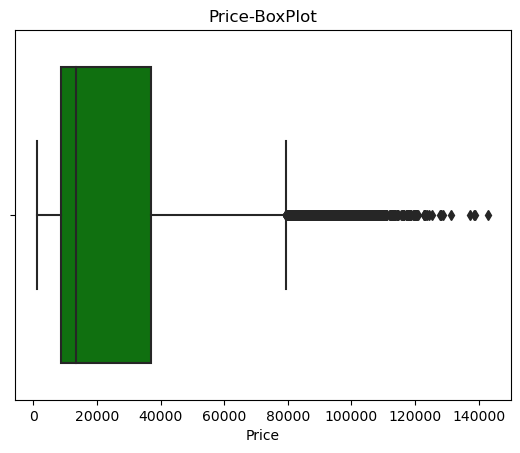

In [74]:
sns.boxplot(data=df, x='Price',color="green")
plt.title('Price-BoxPlot')

There are outliers in the price column. Let us plot a histogram and see.

Text(0.5, 1.0, 'Distribution of Price')

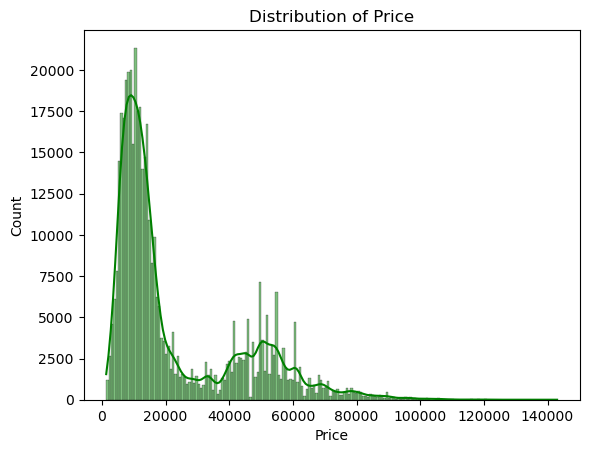

In [75]:
sns.histplot(data=df, x="Price",kde=True,color='green')
plt.title('Distribution of Price')

Price outlier is acceptable because there are different ticket classes like - Economy, Premium Economy, Business and First class.Even though the mean is around 20000, we can see here that the median is approximately 14000. On the second graph, we can see that the dispersion seems to be composed by two gaussian curves. From 1000 to 30000 there is one peak, corresponding to the cheap tickets and the second peak from 40,000 to 80,000 corresponding to the expensive class tickets.

So I have decided not to remove the price outliers.

Now, Check for ouliers in the Duration in hours column.

In [76]:
df["Duration_in_hrs"].describe()

count    445366.000000
mean         12.182491
std           7.299361
min           0.750000
25%           6.500000
50%          11.250000
75%          16.333333
max          43.583333
Name: Duration_in_hrs, dtype: float64

Text(0.5, 1.0, 'Duration-ViolinPlot')

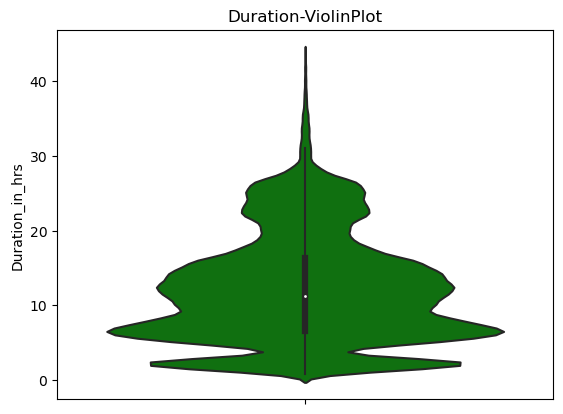

In [77]:
sns.violinplot(data=df, y='Duration_in_hrs',color="green")

plt.title("Duration-ViolinPlot")

There are outliers in duration column. The maximum value is 43 hrs. Let us see those observations with high durations.

In [78]:
df.loc[df['Duration_in_hrs']>40].head(3)

,Date of Journey,Total Stops,Price,Airline,Flight_Code,Class,Source,Destination,Days_left,Journey_day,Dep,Arr,Route,Duration_in_hrs
36912,2023-01-16,2+-sto,30424,Vistara,UK-959,PREMIUMECONOMY,Delhi,Hyderabad,1,Monday,Morning,Early Morning,Delhi-->Hyderabad,41.583333
38208,2023-01-21,2+-sto,20270,Vistara,UK-959,PREMIUMECONOMY,Delhi,Hyderabad,6,Saturday,Morning,Early Morning,Delhi-->Hyderabad,41.583333
38471,2023-01-22,2+-sto,18702,Vistara,UK-959,PREMIUMECONOMY,Delhi,Hyderabad,7,Sunday,Morning,Early Morning,Delhi-->Hyderabad,41.583333


Let us find the average, minimum and maximum duration for each route.

In [79]:
df.groupby(["Route","Class","Total Stops"])['Duration_in_hrs'].agg(['min','mean','max'])

min       mean  \
Route                 Class          Total Stops                         
Ahmedabad-->Bangalore BUSINESS       1-stop        3.666667  14.540577   
                                     2+-sto       13.416667  13.416667   
                      ECONOMY        1-stop        3.666667  12.415107   
                                     2+-sto        7.250000  14.285714   
                                     non-st        2.000000   2.177963   
...                                                     ...        ...   
Mumbai-->Kolkata      ECONOMY        2+-sto        5.500000  18.109231   
                                     non-st        2.333333   2.656190   
                      PREMIUMECONOMY 1-stop        4.750000  12.234848   
                                     2+-sto        7.583333  20.317179   
                                     non-st        2.750000   2.750000   

                                                        max  
Route                 Class          Total Stops             
Ahmedabad-->Bangalore BUSINESS       1-stop       29.750000  
                                     2+-sto       13.416667  
                      ECONOMY        1-stop       42.083333  
                                     2+-sto       28.333333  
                                     non-st        2.500000  
...                                                     ...  
Mumbai-->Kolkata      ECONOMY        2+-sto       35.916667  
                                     non-st        3.083333  
                      PREMIUMECONOMY 1-stop       27.583333  
                                     2+-sto       40.333333  
                                     non-st        2.750000  

[320 rows x 3 columns]

By using capping method, let's replace the durations with 75percentile values. Because having huge difference in durations for the same route does not make any sense.

In [80]:
data=df.groupby(["Route"])['Duration_in_hrs'].describe().reset_index()[['Route','75%']]
data.head(3)

,Route,75%
0,Ahmedabad-->Bangalore,15.916667
1,Ahmedabad-->Chennai,18.833333
2,Ahmedabad-->Delhi,15.583333


In [81]:
#Merge data with df

df_new = df.merge(data,on="Route",how="left")
df_new.head(3)

,Date of Journey,Total Stops,Price,Airline,Flight_Code,Class,Source,Destination,Days_left,Journey_day,Dep,Arr,Route,Duration_in_hrs,75%
0,2023-01-16,non-st,5335,SpiceJet,SG-8169,ECONOMY,Delhi,Mumbai,1,Monday,Night,Late Night,Delhi-->Mumbai,2.083333,14.25
1,2023-01-16,non-st,5899,Indigo,6E-2519,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.333333,14.25
2,2023-01-16,non-st,5801,GO FIRST,G8- 354,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.166667,14.25


Text(0.5, 1.0, 'Duration-Boxplot')

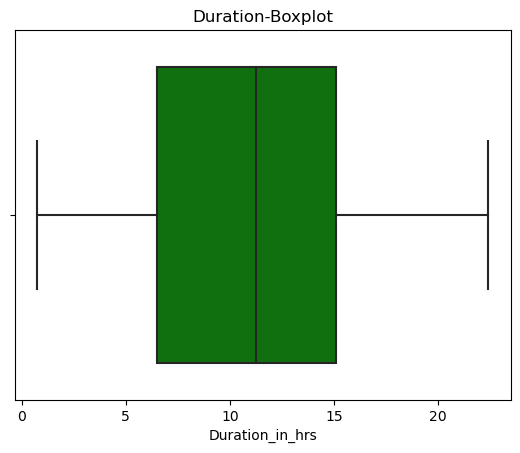

In [82]:
#replace the duration based on condition
#if the duration is greater than 75percentile value replace it with 75percentile
mask = df_new['Duration_in_hrs']>df_new['75%']
df_new.loc[mask,'Duration_in_hrs'] = df_new['75%']

#check for outliers again
sns.boxplot(data=df_new, x="Duration_in_hrs",color="green")
plt.title('Duration-Boxplot')

Finally, the outliers are removed.

Drop the Flight_code and 75% columns.

In [83]:
df_new.drop(['Flight_Code','75%'],axis=1,inplace=True)

In [84]:
df_new.columns

Index(['Date of Journey', 'Total Stops', 'Price', 'Airline', 'Class', 'Source',
       'Destination', 'Days_left', 'Journey_day', 'Dep', 'Arr', 'Route',
       'Duration_in_hrs'],
      dtype='object')

### **Exploratory Data Analysis**

**1. Date of Journey Vs Price**

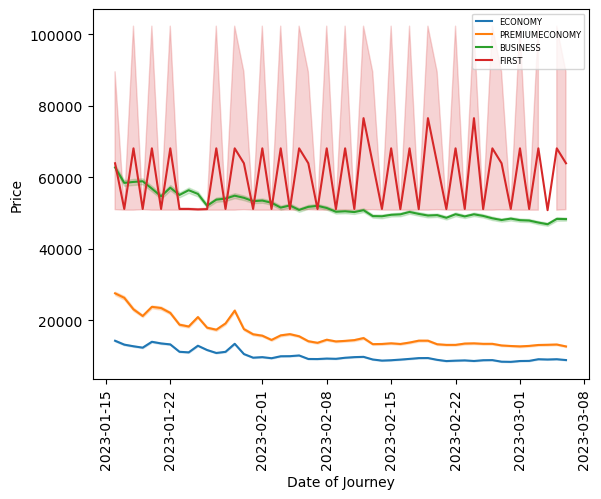

In [85]:
sns.lineplot(data=df_new, x='Date of Journey', y="Price",hue="Class")
plt.xticks(rotation=90)
plt.legend(fontsize=6)
plt.show()

**Insights**
* The Economy tickets are cheaper than Premium Economy - Our data also confirms this.
* Business class and First class tickets are expensive.
* We have data from January 16, 2023 to March 8, 2023 (52 days). 
* The price of tickets is almost stable except for First class tickets over the 3 month period.

**2. Class-Wise Ticket Booking**

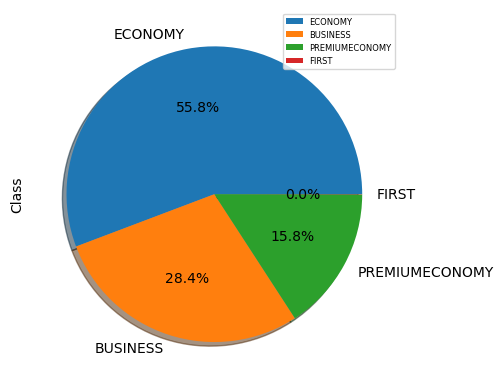

In [86]:
df_new["Class"].value_counts().plot(kind="pie",autopct="%1.1f%%",shadow=True)
plt.legend(fontsize=6,loc=1)
plt.show()

* Most tickets booked are in the Economy Class, as most people prefers to travel at a low cost.
* Eventhough the Premium Economy tickets are less expensive than Business class, the rich prefers comfort and better service over price.

**3. Count of Categorical Variables**

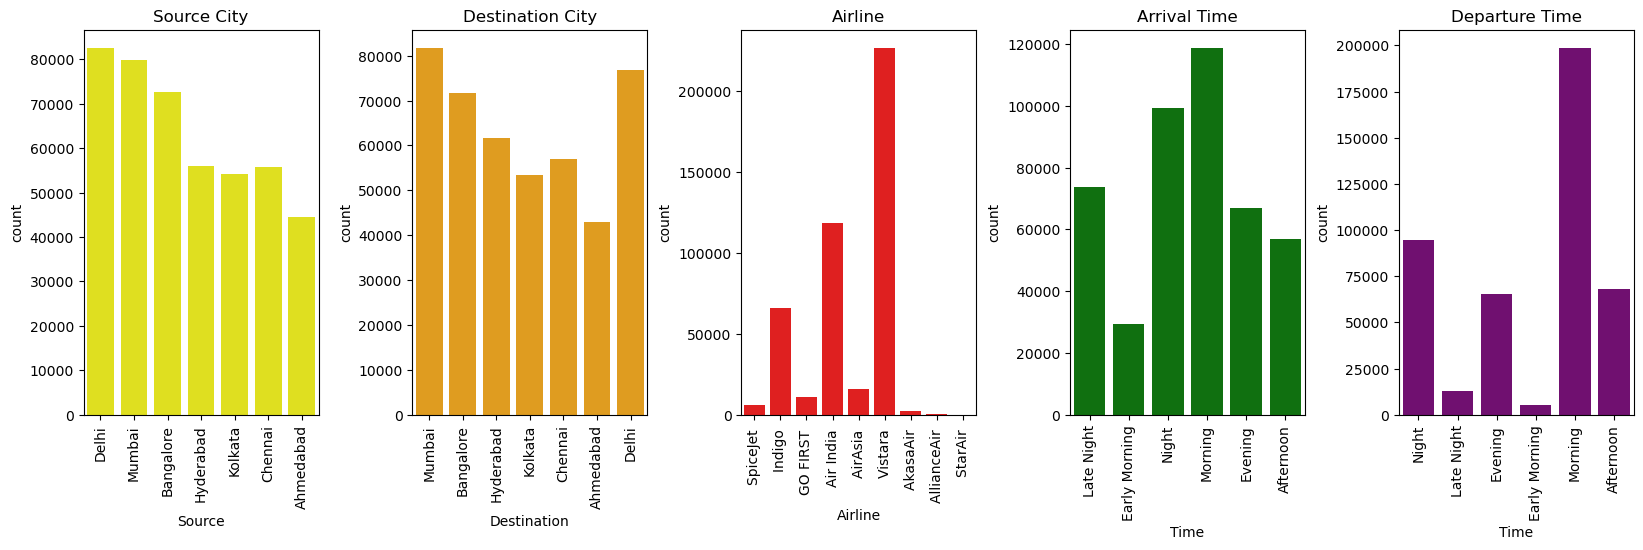

In [87]:
#plotting all plots in same line
fig,ax = plt.subplots(1,5,figsize=(20,5))

#Adjusting the space in betweeen
fig.subplots_adjust(wspace=0.4)

#subplot1- Source
plt.subplot(1,5,1)
sns.countplot(x='Source',data=df_new,color="yellow")
plt.title("Source City")
plt.xticks(rotation=90)

#subplot2 = Destination
plt.subplot(1,5,2)
sns.countplot(x='Destination',data=df_new,color="orange")
plt.title("Destination City")
plt.xticks(rotation=90)

#subplot3 = Airline
plt.subplot(1,5,3)
sns.countplot(x='Airline',data=df_new,color="red")
plt.title("Airline")
plt.xticks(rotation=90)

#subplot4 = Arrival Time
plt.subplot(1,5,4)
sns.countplot(x='Arr',data=df_new,color="green")
plt.title("Arrival Time")
plt.xlabel("Time")
plt.xticks(rotation=90)

#subplot5 = Departure Time
plt.subplot(1,5,5)
sns.countplot(x='Dep',data=df_new,color="purple")
plt.title("Departure Time")
plt.xlabel("Time")
plt.xticks(rotation=90)

plt.show()


**Insights**
* Delhi, Mumbai are the busiest airports.
* Vistara operates the highest number of flights followed by Air India and Indigo.
* Majority flights departs in the morning.
* Most departures are during 6AM-12PM.
* Most of the aarivals are also during that time.

**4. Airline Vs. Price**

Let us choose the busisest route and plot the ticket fare offered by different airlines in that route.

In [88]:
df_new["Route"].value_counts().head(3)

Delhi-->Mumbai       19113
Delhi-->Bangalore    17508
Bangalore-->Delhi    17368
Name: Route, dtype: int64

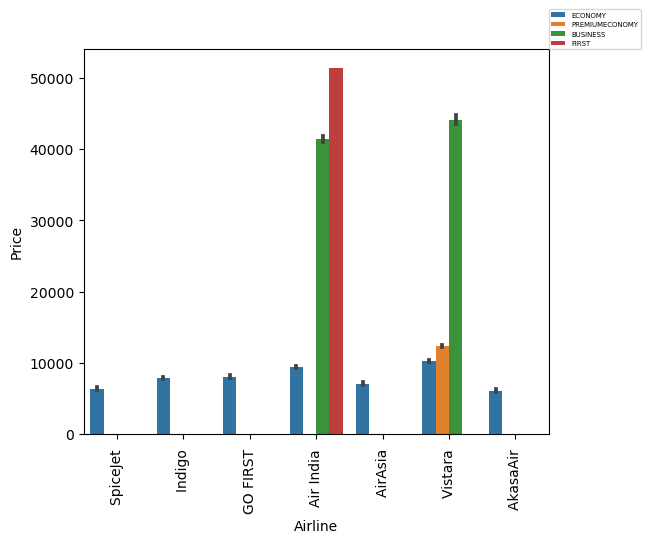

In [89]:
plt.figure(figsize=(6,5))
sns.barplot(data=df_new[df_new["Route"]=="Delhi-->Mumbai"], x="Airline",y="Price",hue="Class")
plt.legend(loc=(1,1),fontsize=5)
plt.xticks(rotation=90)
plt.show()

**Insights**
* Cheapest economy flights are operated by AkasaAir and SpiceJet
* Economy tickets of Vistara are expensive followed by Air India.
* Vistara's Business class tickets are expensive than Air India's business class.

**5. Flight Price based on Departure time & Arrival Time**

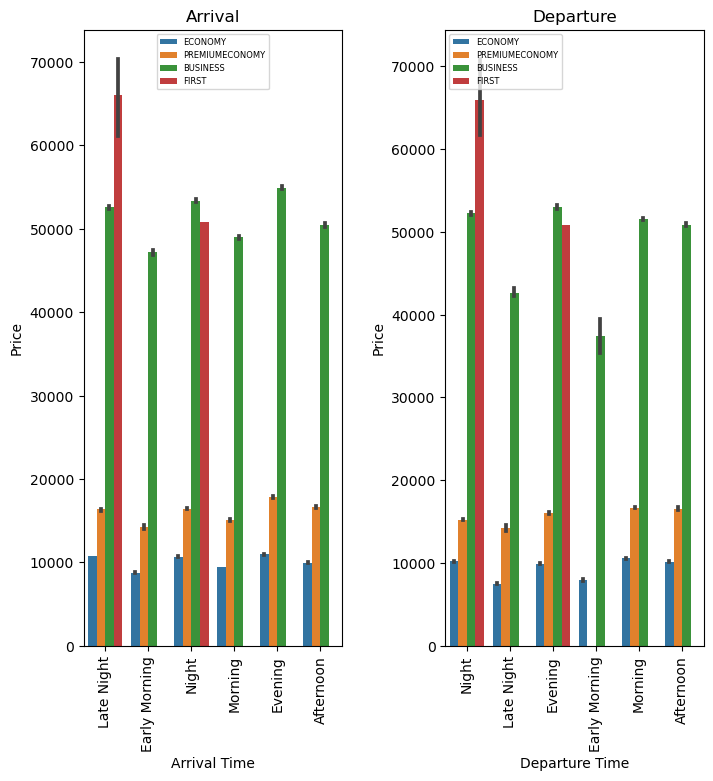

In [90]:
fig,ax = plt.subplots(1,2,figsize=(8,8))
plt.subplots_adjust(wspace=0.4)
sns.barplot(data=df_new,x='Dep',y="Price",hue="Class")
plt.xticks(rotation=90)
plt.xlabel("Departure Time")
plt.title("Departure")
plt.legend(fontsize=6)

plt.subplot(1,2,1)
sns.barplot(data=df_new,x='Arr',y="Price",hue="Class")
plt.xticks(rotation=90)
plt.xlabel("Arrival Time")
plt.title("Arrival")
plt.legend(fontsize=6)

plt.show()

**Insights**
* For Economy Flights - Early Morning flights(12 AM - 6 AM) are the cheapest
* Flights offering First Class tickets operates during Evening and Night.
* Flights arriving and departing during evening time have expensive business class tickets.
* The higher price may be due to the high demand during those times.
* Early morning Business Class tickets are cheaper than the rest.

**6. Duration Vs. Price**

In [91]:
dur = df_new[(df_new["Class"]=="ECONOMY")].groupby(["Duration_in_hrs"])["Price"].mean().reset_index()
dur.head(3)

,Duration_in_hrs,Price
0,0.750000,1972.285714
1,0.833333,3298.135802
2,0.916667,2681.069959


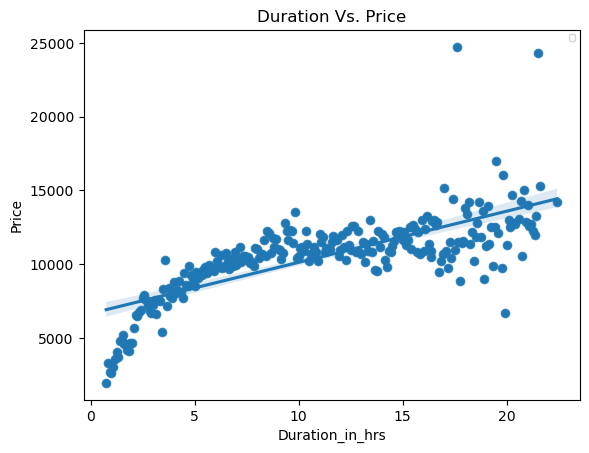

In [92]:
sns.scatterplot(data=dur, x='Duration_in_hrs',y="Price")
sns.regplot(data=dur, x='Duration_in_hrs',y='Price')
plt.title("Duration Vs. Price")
plt.legend(fontsize=6)
plt.show()

**Insights**
* With trip duration the Airticket fare also increases.

**7. Days_left Vs. Price**

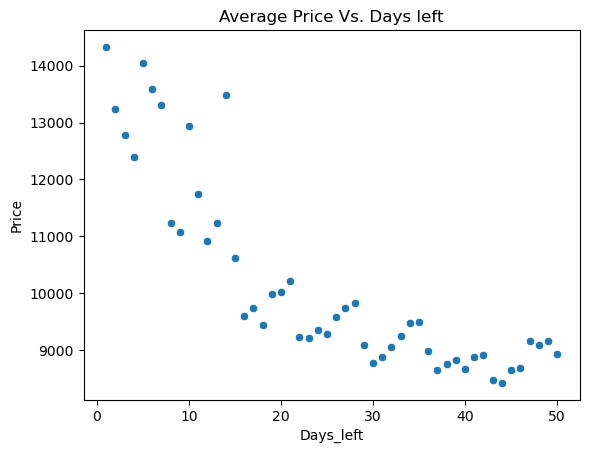

In [93]:
df_days = df_new[(df_new["Class"]=="ECONOMY")].groupby(['Days_left'])['Price'].mean().reset_index()


ax = sns.scatterplot(x="Days_left", y="Price", data=df_days).set_title("Average Price Vs. Days left")

<Axes: xlabel='Days_left', ylabel='Price'>

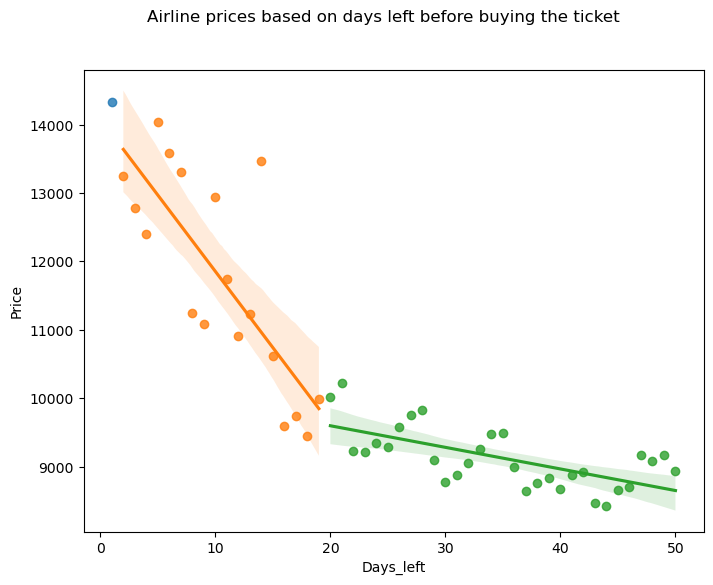

In [94]:
plt.figure(figsize=(8,6)).suptitle('Airline prices based on days left before buying the ticket', fontsize=12)

ax = plt.axes()

sns.regplot(x=df_days.loc[df_days["Days_left"]==1].Days_left, y=df_days.loc[df_days["Days_left"]==1].Price, fit_reg=False, ax=ax)
sns.regplot(x=df_days.loc[(df_days["Days_left"]>1)&(df_days["Days_left"]<20)].Days_left, y=df_days.loc[(df_days["Days_left"]>1)&(df_days["Days_left"]<20)].Price, fit_reg=True, ax=ax)
sns.regplot(x=df_days.loc[df_days["Days_left"]>=20].Days_left, y=df_days.loc[df_days["Days_left"]>=20].Price, fit_reg=True, ax=ax)

**Insights**
* The graph highlights how the prices rise slowly and then drastically start rising 20 days before the flight.
* So booking the tickets early is good for the passenger.

**8. Journey Day**

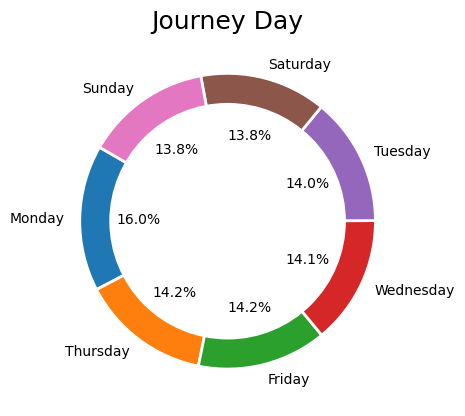

In [95]:
counts = df_new['Journey_day'].value_counts()

# Create the pie chart
fig, ax = plt.subplots()
pie = ax.pie(counts,labels= counts.index, autopct='%1.1f%%', 
                 wedgeprops={ 'linewidth' : 2, 'edgecolor' : 'white' },
                 startangle=150,labeldistance=1.1)
    
# Add a circle at the center of the chart to create the donut shape
center_circle = plt.Circle((0, 0), 0.8, fc='white')
fig.gca().add_artist(center_circle)

    
plt.title('Journey Day', fontsize=18)

# Show the plot
plt.show()

**Insights**
* 16% flights operate on mondays.
* There is no sharp variation in the number of flights operated across a week.

**9. Journey Day Vs Price**

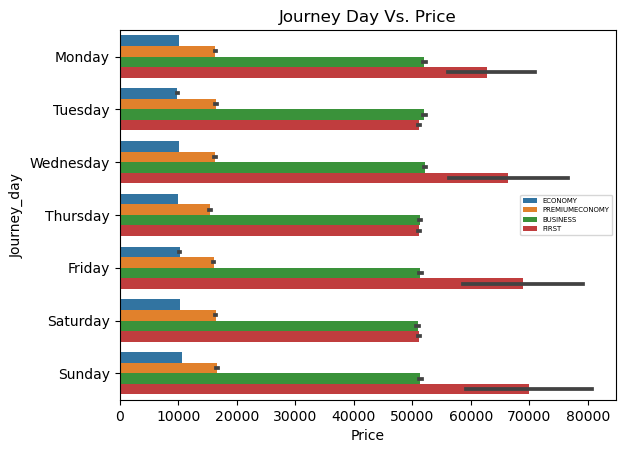

In [96]:
sns.barplot(data=df_new, y="Journey_day", x="Price",hue="Class")
plt.title("Journey Day Vs. Price")
plt.legend(fontsize=5)
plt.show()

The variation of Price across the week is minimal.

**10. Stops Vs Price**

Let us consider the flights from the busiest airport - Delhi and Class - Economy.

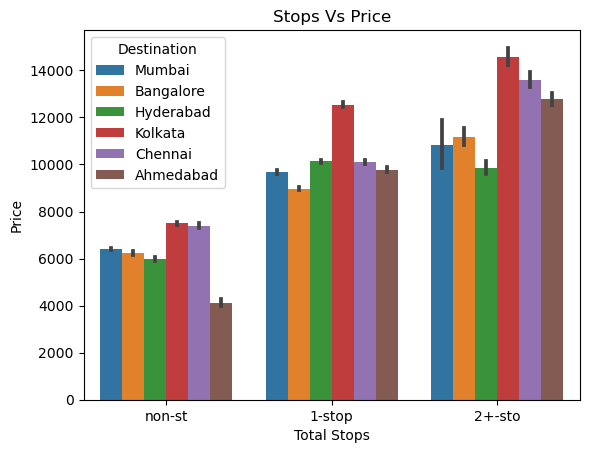

In [97]:
sns.barplot(data=df_new[(df_new["Source"]=="Delhi")&(df_new["Class"]=="ECONOMY")],x="Total Stops",y="Price",hue="Destination")

plt.title("Stops Vs Price")
plt.show()

**Insights**
* It seems like as the number of stops increases th airfare also increases.
* Except for Delhi-Hyderabad flight all others show this trend.
* Non stop flights have less fare among others.

### **Take Away Points**


1. There is a big gap between flight tickets in business and economy. In average business tickets are 6.5 times more expensive than economy tickets.

2. Vistara and AirIndia seems to be the most expensive companies and AirAsia and Akasa Air the cheapest. However for business tickets, only Vistara and AirIndia are available, and Vistara is slightly more expensive.

3. In general, prices rise quite slowly until 20 days before the flight after which the prices rise drastically. 

4. The longer the flight is the more expensive the tickets are until it reaches around 20 hours.

5. For the time of the flight:

 It seems that early mormimg arrivals are more cheaper and evening arrivals are expensive.
 It seems that late night departures are cheaper.

6. In general, the more stops there are, the more expensive the flight ticket is.

### **Model Development**

In [98]:
#Let us make a copy of df_new
df_final = df_new.copy()

In [99]:
df_final.columns

Index(['Date of Journey', 'Total Stops', 'Price', 'Airline', 'Class', 'Source',
       'Destination', 'Days_left', 'Journey_day', 'Dep', 'Arr', 'Route',
       'Duration_in_hrs'],
      dtype='object')

Map the ordinal categorical columns to corresponding numerical values.

In [100]:
def preprocessing(df):
    
    #Encode the ordinal variables Total Stops,Class,Journey_day,Dep,Arr
    
    df['Total Stops'] = df['Total Stops'].replace({'non-st':0,'1-stop':1,'2+-sto':2}).astype(int)
    df['Class'] =df['Class'].replace({'ECONOMY':0,'PREMIUMECONOMY':1,'BUSINESS':2,'FIRST':3}).astype(int)
    df['Journey_day'] = df["Journey_day"].map({'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6})
    df['Dep'] = df['Dep'].map({'Early Morning':0,'Morning':1,'Afternoon':2,'Evening':3,'Night':4,'Late Night':5})
    df['Arr'] = df['Arr'].map({'Early Morning':0,'Morning':1,'Afternoon':2,'Evening':3,'Night':4,'Late Night':5})
    
    #Create dummy variables for Airline, Source, Destination
    
    cols = ['Airline','Source','Destination']
    dummies = pd.get_dummies(df[cols],drop_first=True)
    df = pd.concat([df,dummies],axis=1)
    
    df.drop(['Date of Journey','Airline','Source', 'Destination','Route'],axis=1,inplace=True)
    
    return df


In [101]:
df_preprocessed = preprocessing(df_final)

In [102]:
df_preprocessed.columns

Index(['Total Stops', 'Price', 'Class', 'Days_left', 'Journey_day', 'Dep',
       'Arr', 'Duration_in_hrs', 'Airline_AirAsia ', 'Airline_AkasaAir ',
       'Airline_AllianceAir ', 'Airline_GO FIRST ', 'Airline_Indigo ',
       'Airline_SpiceJet ', 'Airline_StarAir ', 'Airline_Vistara ',
       'Source_Bangalore', 'Source_Chennai', 'Source_Delhi',
       'Source_Hyderabad', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Bangalore', 'Destination_Chennai', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_Mumbai'],
      dtype='object')

In [103]:
df_preprocessed.dtypes

Total Stops                int64
Price                      int64
Class                      int64
Days_left                  int64
Journey_day                int64
Dep                        int64
Arr                        int64
Duration_in_hrs          float64
Airline_AirAsia            uint8
Airline_AkasaAir           uint8
Airline_AllianceAir        uint8
Airline_GO FIRST           uint8
Airline_Indigo             uint8
Airline_SpiceJet           uint8
Airline_StarAir            uint8
Airline_Vistara            uint8
Source_Bangalore           uint8
Source_Chennai             uint8
Source_Delhi               uint8
Source_Hyderabad           uint8
Source_Kolkata             uint8
Source_Mumbai              uint8
Destination_Bangalore      uint8
Destination_Chennai        uint8
Destination_Delhi          uint8
Destination_Hyderabad      uint8
Destination_Kolkata        uint8
Destination_Mumbai         uint8
dtype: object

In [104]:
df_preprocessed.head(3)

,Total Stops,Price,Class,Days_left,Journey_day,Dep,Arr,Duration_in_hrs,Airline_AirAsia,Airline_AkasaAir,...,Source_Delhi,Source_Hyderabad,Source_Kolkata,Source_Mumbai,Destination_Bangalore,Destination_Chennai,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_Mumbai
0,0,5335,0,1,0,4,5,2.083333,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,5899,0,1,0,5,0,2.333333,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,5801,0,1,0,5,0,2.166667,0,0,...,1,0,0,0,0,0,0,0,0,1


#### **Splitting features and target columns**

In [105]:
X = df_preprocessed.drop('Price',axis=1)
y = df_preprocessed['Price']

#### **Splitting Train and Test data**

In [106]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1,shuffle=True)

In [107]:
rs = RobustScaler()
X_train = rs.fit_transform(X_train)
X_test = rs.transform(X_test)

Here multiple Machine Learining algorithms are used.

### **Model1- KNeighborsRegressor**

In [108]:
#Model building
knn = KNeighborsRegressor()

knn.fit(X_train,y_train)

#predicting
y_pred = knn.predict(X_test)

#model evaluation
print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error:",mean_squared_error(y_test,y_pred))
print("R2 Score:",r2_score(y_test,y_pred))

Mean Absolute Error: 2928.7344495172515
Mean Squared Error: 30182577.48821705
R2 Score: 0.9279008955557326


**R2 Score KNN : 0.92**

**Mean Absolute Error : 2928.73**

### **Model2- LinearRegression**

In [109]:
#Model building
lr = LinearRegression()

lr.fit(X_train,y_train)

#prediction
y_pred = lr.predict(X_test)

#model evaluation
print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error:",mean_squared_error(y_test,y_pred))
print("R2 Score",r2_score(y_test,y_pred))

Mean Absolute Error: 6818.6272381765075
Mean Squared Error: 95983081.29360268
R2 Score 0.7707189120686704


**R2 Score : 0.77**

**Mean Absolute Error : 6818**

### **Model 3 - DecisionTreeRegressor**

In [110]:
#model building
dt = DecisionTreeRegressor(random_state=1)

dt.fit(X_train,y_train)

#prediction
y_pred = dt.predict(X_test)

#model evaluation
print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error:",mean_squared_error(y_test,y_pred))
print("R2 Score",r2_score(y_test,y_pred))

Mean Absolute Error: 2670.432370866167
Mean Squared Error: 35346694.15198906
R2 Score 0.9155650310375671


**R2 Score: 0.91**

**Mean Absolute Error: 2670.43**

### **Model 4- XGBRegressor**

In [111]:
#model building
xg = XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10,random_state=1)
xg.fit(X_train,y_train)
#prediction
y_pred = xg.predict(X_test)

#model evaluation
print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error:",mean_squared_error(y_test,y_pred))
print("R2 Score",r2_score(y_test,y_pred))

Mean Absolute Error: 2738.1150738289216
Mean Squared Error: 23201494.38817884
R2 Score 0.9445770670907933


**R2 Score : 0.94**

**Mean Absolute Error:2738**

### **Model 5- RandomForestRegressor**

In [112]:
#model building
rf = RandomForestRegressor(n_estimators = 300,random_state=1)

rf.fit(X_train,y_train)

#prediction
y_pred = rf.predict(X_test)

#model evaluation
print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error:",mean_squared_error(y_test,y_pred))
print("R2 Score",r2_score(y_test,y_pred))

Mean Absolute Error: 2277.0373200354325
Mean Squared Error: 20895781.582186442
R2 Score 0.9500848746490651


**R2 Score : 0.95**

**Mean Absolute Error : 2277**

**The model that gives the best result is the RandomForestRegressor with an R2 score equals to 0.95 and a MAE score equals to 2277.**

In [113]:
price_data = pd.DataFrame({"Predicted Price":np.rint(rf.predict(X_test)),'Actual Price':y_test}).reset_index(drop=True)
price_data.tail(20)

,Predicted Price,Actual Price
133590,13526.0,13042
133591,10469.0,12178
133592,13363.0,15248
133593,39642.0,39377
133594,37417.0,37417
133595,5358.0,3975
133596,15282.0,14435
133597,13790.0,14034
133598,13792.0,13971
133599,5680.0,5394


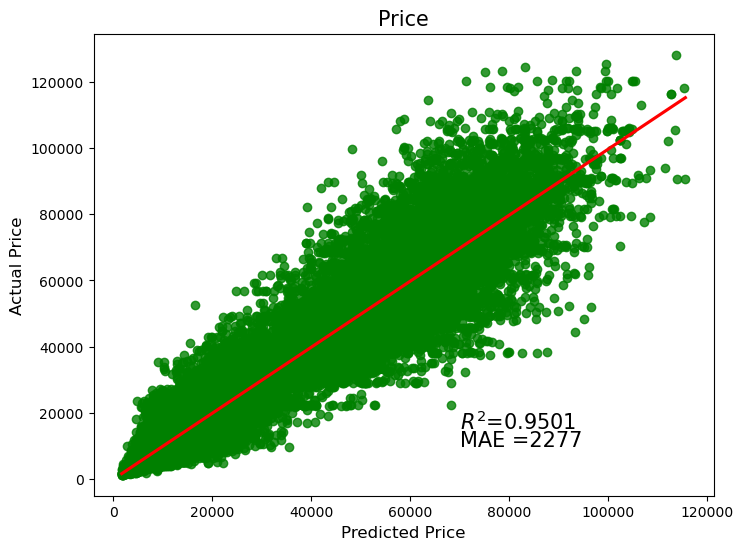

In [114]:
plt.figure(figsize=(8,6))
plt.title("Price",fontsize=15)
plt.ylabel('Test Predicted price',fontsize=12)
plt.xlabel('Test Actual price',fontsize=12)
sns.regplot(data = price_data, x = 'Predicted Price', y = 'Actual Price',scatter_kws={"color": "green"}, line_kws={"color": "red"})

score_r2 = r2_score(y_test, y_pred) 
score_mae = mean_absolute_error(y_test, y_pred)
plt.text(70000,15000,'$ R^{2} $=' + str(round(score_r2, 4)),fontsize=15)
plt.text(70000,10000,'MAE =' + str(round(score_mae)),fontsize=15)
plt.show()

#### **Checking Feature Importance**

In [115]:
feature_scores = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_scores


Class                    8.027285e-01
Duration_in_hrs          7.435140e-02
Days_left                3.608729e-02
Arr                      1.226817e-02
Airline_Vistara          1.142134e-02
Dep                      1.035486e-02
Journey_day              9.934843e-03
Source_Delhi             4.510970e-03
Source_Kolkata           4.026772e-03
Destination_Kolkata      3.987471e-03
Destination_Delhi        3.839905e-03
Destination_Mumbai       3.537577e-03
Source_Mumbai            2.981513e-03
Destination_Bangalore    2.866639e-03
Source_Bangalore         2.658852e-03
Total Stops              2.587169e-03
Destination_Chennai      2.490089e-03
Source_Chennai           2.330058e-03
Source_Hyderabad         2.251905e-03
Destination_Hyderabad    2.215435e-03
Airline_AirAsia          1.001436e-03
Airline_Indigo           9.550646e-04
Airline_GO FIRST         3.401797e-04
Airline_SpiceJet         2.554609e-04
Airline_StarAir          1.082836e-05
Airline_AkasaAir         5.528703e-06
Airline_Alli

* The Class feature has highest importance.
* The columns Airline_AllianceAir has the least significance.

So let's remove the least important 3 columns and check the mean absolute error and r2 score again.

In [116]:
df_preprocessed.columns

Index(['Total Stops', 'Price', 'Class', 'Days_left', 'Journey_day', 'Dep',
       'Arr', 'Duration_in_hrs', 'Airline_AirAsia ', 'Airline_AkasaAir ',
       'Airline_AllianceAir ', 'Airline_GO FIRST ', 'Airline_Indigo ',
       'Airline_SpiceJet ', 'Airline_StarAir ', 'Airline_Vistara ',
       'Source_Bangalore', 'Source_Chennai', 'Source_Delhi',
       'Source_Hyderabad', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Bangalore', 'Destination_Chennai', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_Mumbai'],
      dtype='object')

In [117]:
X1 = df_preprocessed.drop(['Price','Airline_AllianceAir ','Airline_AkasaAir ','Airline_StarAir '],axis=1)
y1 = df_preprocessed['Price']

In [118]:
X_train,X_test,y_train,y_test = train_test_split(X1,y1,test_size=0.3,random_state=1,shuffle=True)

In [119]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [120]:
#model building
rf1 = RandomForestRegressor(n_estimators = 300,random_state=1)

rf1.fit(X_train,y_train)

#prediction
y_pred = rf1.predict(X_test)

#model evaluation
print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
print("Mean Squared Error:",mean_squared_error(y_test,y_pred))
print("R2 Score",r2_score(y_test,y_pred))

Mean Absolute Error: 2276.671257013658
Mean Squared Error: 20886166.213058237
R2 Score 0.9501078435125864


**Mean Absolute Error: 2276.67**

**R2 Score 0.950**

After dropping the least important columns the mean absolute error slightly decreased.

### **Saving the trained model**

In [121]:
import pickle

#save the model
pickle.dump(rf , open('Airplane_model.pkl', 'wb'))
#save the scaler
pickle.dump(rs, open('Scaler.pkl', 'wb'))

### **Loading the Saved Model**

In [122]:
loaded_model = pickle.load(open('Airplane_model.pkl','rb'))

In [123]:
df_preprocessed.iloc[0].values

array([0.00000000e+00, 5.33500000e+03, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 4.00000000e+00, 5.00000000e+00, 2.08333333e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00])

In [124]:
y_prediction = loaded_model.predict(rs.transform([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 4.00000000e+00, 5.00000000e+00, 2.08333333e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]))

y_prediction

array([5758.17])

Now let's deploy the ML model using Streamlit library.